In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import imutils

In [55]:
def ccw(A, B, C):
    # returns true if A, B, and C are listed in counterclockwise order
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])


def intersect(A, B, C, D):
    # returns true if line segment AB intersects line segment CD
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)


def calc_dist(A, B):
    # returns distance between point A and point B
    dx = abs(A[0] - B[0])
    dy = abs(A[1] - B[1])
    dist = math.sqrt(dx**2 + dy**2)
    return dist

In [59]:
def detect_cone(img, outline=False, label=False):
    # contours and bounding rectangles that will be returned
    conts, rects = [], []
    
    # find contours
    blur_img = cv2.GaussianBlur(img, (49, 49), 0)
    hsv_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)
    mask_img = cv2.inRange(hsv_img, np.array([90, 150, 150]), np.array([110, 255, 255]))
    contours, hierarchy = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for i, cont in enumerate(contours):
        # filter out contours with a small area
        area = cv2.contourArea(cont)
        if area >= 1000:
            conts.append(cont)
            
            # find the smallest rectangle around the contour
            rect = cv2.minAreaRect(cont)
            rect = cv2.boxPoints(rect)
            rect = np.int0(rect)
            rects.append(rect)
            
            # draw the contour and rectangle
            if outline:
                cv2.drawContours(img, [cont], -1, (0, 0, 255), 2)
                cv2.drawContours(img, [rect], -1, (255, 0, 0), 2)
                
            # label the coordinates of the vertices of the rectangle
            if label:
                for j, point in enumerate(rect):
                    x = rect[j][0]
                    y = rect[j][1]
                    cv2.putText(img, str(x) + ", " + str(y), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    conts = np.asarray(conts)
    rects = np.asarray(rects)
    
    return conts, rects
    

def detect_base(img, rects, draw_line=False):
    b1, b2, base = [], [], []
    base_index = 0
    
    # find the lines between the possible bases
    points = rects.reshape(8, 2)
    for i in range(4):
        p1 = points[(i+0) % 4]
        p2 = points[(i+1) % 4]
        p3 = points[(i+2) % 4]
        p4 = points[(i+3) % 4]
        p5 = points[((i+4) % 4)+4]
        p6 = points[((i+5) % 4)+4]
        p7 = points[((i+6) % 4)+4]
        p8 = points[((i+7) % 4)+4]

        if intersect(p1, p5, p2, p3) or intersect(p1, p5, p3, p4) or intersect(p1, p5, p6, p7) or intersect(p1, p5, p7, p8):
            b1.append(p1)
            b2.append(p5)
            # if draw_line:
            #     cv2.line(img, tuple(p1), tuple(p5), (255, 255, 255), 2)
                        
    b1 = np.asarray(b1)
    b2 = np.asarray(b2)
    
    # find the base using the lengths of the possible bases
    if calc_dist(b1[0], b1[1]) > calc_dist(b2[0], b2[1]):
        base = rects[0]
        base_index = 0
        if draw_line:
            cv2.line(img, tuple(b1[0]), tuple(b1[1]), (255, 255, 0), 5)
    else:
        base = rects[1]
        base_index = 1
        if draw_line:
            cv2.line(img, tuple(b2[0]), tuple(b2[1]), (255, 255, 0), 5)
    
    return base, base_index


def calc_angle(img, base, base_index, rects, draw_line=False):
    # find the center of the base
    M1 = cv2.moments(base)    
    try:
        cX1 = int((M1["m10"] / M1["m00"]))
        cY1 = int((M1["m01"] / M1["m00"]))
    except:
        cX1 = 0
        cY1 = 0
    c1 = (cX1, cY1)
    
    # find the center of the tip
    M2 = cv2.moments(rects[(base_index+1) % 2])
    try:
        cX2 = int((M2["m10"] / M2["m00"]))
        cY2 = int((M2["m01"] / M2["m00"]))
    except:
        cX2 = 0
        cY2 = 0
    c2 = (cX2, cY2)
    
    # find the angle from the base to the tip in degrees, -179 to 180
    angle = -1 * (int(math.degrees(math.atan2(-1 * (cY2-cY1), cX2-cX1)))) + 90
    if angle > 180 and angle <= 270:
        angle -= 360
        
    # draw the line between the base and the tip
    if draw_line:
        cv2.line(img, c1, c2, (255, 255, 255), 2)
        
    return angle

In [60]:
def calc_cone_angle(img):
    # find and label contours and bounding rectangles
    conts, rects = detect_cone(img, True, False)
    
    if len(rects) == 2:
        # find the base of the cone
        base, base_index = detect_base(img, rects, True)
        
        # find the angle between the base and the tip, relative to the y-axis
        angle = calc_angle(img, base, base_index, rects, True)
    
        return img, angle
    
    else:
        return img, 0

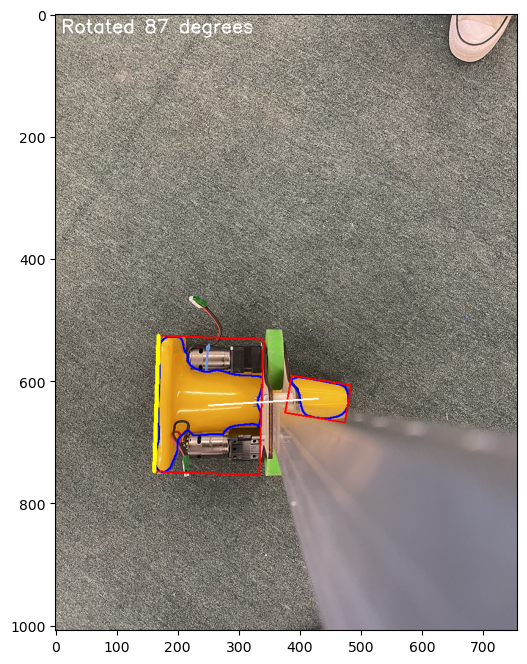

In [91]:
img = mpimg.imread('cone2_small.jpg')
rotated_img = imutils.rotate(img, angle=0)
detected_img, angle = calc_cone_angle(rotated_img)
cv2.putText(detected_img, "Rotated " + str(angle) + " degrees", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

plt.figure(figsize=(8, 8))
plt.imshow(detected_img)
plt.show()